# DecisionTree案例

### 案例：使用sklearn构建决策树模型，预测学生最终是否通过考试，对模型进行调优
- 数据预处理
- sklearn实现决策树
- 决策树可视化
- K折交叉验证
- 模型调优

### 数据集：student_data_DT.csv
该数据集取自华中师范大学云课堂平台中的思想道德修养和法律基础课日志，对象为800名学生，数据字段包含学生的基本信息和行为信息。其中，成绩通过的学生有638人，不通过的有162人。具体字段如下：
- id-学生的ID号 
- UserId，学生的学号
- term，开课学期，一年有2个学期
- UserClass，根据日志中的时间和位置信息计算出的学生类别，共7类
- grade，学生年级，有2015,2016,2017,2018三个年级
- gender，性别
- majorClass，专业类别，即liberal(文科)、science(理科)和art(艺术)
- totalLearningTime，总学习时长，单位为秒
- TimeClassNumber，学习时段个数，最多6个。学习时段如：工作日上午，工作日下午，工作日晚上，周末上午，周末下午，周末晚上
- LocationClassNumber，学习位置个数，最多10个。
- isPassExam，是否通过期末考试（YES，NO）

## 1.数据explore和preprocessing
- 数据探索：缺失值分析（属性的某些值或某些属性缺失），异常值分析（数据集中不合理或明显偏离其它观测值的数据），一致性分析（数据自相矛盾，不相容，多是数据来源不一致，在集成过程导致）
- 数据预处理：缺失值处理（删除、替换、插补等等），异常值处理（删除、视为缺失值、平均值修正），噪声数据（平滑技术处理，如分箱、回归、聚类等）
- 本例数据如下图，数据处理任务包括选定目标变量，丢弃不必要的特征，转换数值，缺失值处理

![jupyter](student_data.png)

### 数据预处理方案
- id-学生的ID号，是顺序编号，用来唯一地标识一名学生，与学生是否通过考试无关，可以丢弃;
- UserId-学生的学号，与学生是否通过考试无关，可以丢弃；
- term-开课学期，可以认为与学生是否通过考试关系不大，可以丢弃；
- UserClass-根据学生位置和时间特点划分的类别，与学习表现有关，保留；
- grade-学生年级，不确定与学生是否通过考试有关，保留；
- gender-性别，可能与学生是否通过考试有关系，保留；
- majorClass-专业类别，这门课是思想道德修养与法律基础，文科的学生可能更容易通过考试，保留；
- totalLearningTime-学生总学习时长，与学习成绩密切相关，保留；
- TimeClass-学习时段个数，与学习表现有关，保留；
- LocationClass-学生学习的地理位置个数，可能与学习表现有关，保留；
- isPassExam-是否通过考试，是我们分析的目标变量，保留；


导入数据preprocessing用到的包

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd

用pandas处理数据

In [5]:
data = pd.read_csv('student_data_DT2.csv', index_col=0) #使用pandas读取数据
print(data)

      UserId    term  UserClass  grade  gender  majorClass  totalLearningTime  \
1     213930  201701          2   2016       2           1              57941   
2     213931  201701          4   2016       1           1              19306   
3     213932  201502          2   2015       2           1              41767   
4     213933  201701          5   2016       2           1               8167   
5     213934  201702          4   2017       2           1               8626   
...      ...     ...        ...    ...     ...         ...                ...   
1230  215782  201502          4   2016       1           2               1311   
1231  215812  201701          1   2016       1           2              31919   
1232  215813  201502          1   2015       2           2              36678   
1233  215825  201502          2   2015       1           2               5267   
1234  215826  201702          6   2017       1           2                  3   

      TimeClassNumber  Loca

丢弃无用的特征：ID、UserId、term

In [66]:
data.drop(['UserId', 'term'], axis=1, inplace=True)## 丢弃无用的特征
data.head(20)#打印前20行数据

,UserClass,grade,gender,majorClass,totalLearningTime,TimeClassNumber,LocationClassNumber,isPassExam
1,0,2016,2,0,57941,6,4,0
2,1,2016,1,0,19306,4,5,0
3,0,2015,2,0,41767,5,3,0
4,2,2016,2,0,8167,3,1,0
5,1,2017,2,0,8626,3,5,0
6,3,2016,2,0,35269,5,3,0
7,3,2016,1,0,99769,6,7,0
8,4,2015,1,0,2148,2,3,0
9,0,2017,2,0,90904,6,3,0
10,4,2016,2,0,42092,4,2,0


缺失值处理：TotalLearningTime 有缺失值，可以用平均值代替。

In [69]:
table =data[data['totalLearningTime'].isnull().values==False]
score_avg = data['totalLearningTime'].mean()
table = data['totalLearningTime'].fillna(value=score_avg)
data['totalLearningTime'] = table
data.head(20)#打印前20行数据

,UserClass,grade,gender,majorClass,totalLearningTime,TimeClassNumber,LocationClassNumber,isPassExam
1,0,2016,2,0,57941,6,4,0
2,1,2016,1,0,19306,4,5,0
3,0,2015,2,0,41767,5,3,0
4,2,2016,2,0,8167,3,1,0
5,1,2017,2,0,8626,3,5,0
6,3,2016,2,0,35269,5,3,0
7,3,2016,1,0,99769,6,7,0
8,4,2015,1,0,2148,2,3,0
9,0,2017,2,0,90904,6,3,0
10,4,2016,2,0,42092,4,2,0


替换值：①gender为英文，有两种，用数字代替；

In [72]:
data['gender'] = (data['gender']=='male').astype('int') #处理性别数据，用0和1替换
data.head(20)#打印前20行数据

,UserClass,grade,gender,majorClass,totalLearningTime,TimeClassNumber,LocationClassNumber,isPassExam
1,0,2016,0,0,57941,6,4,0
2,1,2016,0,0,19306,4,5,0
3,0,2015,0,0,41767,5,3,0
4,2,2016,0,0,8167,3,1,0
5,1,2017,0,0,8626,3,5,0
6,3,2016,0,0,35269,5,3,0
7,3,2016,0,0,99769,6,7,0
8,4,2015,0,0,2148,2,3,0
9,0,2017,0,0,90904,6,3,0
10,4,2016,0,0,42092,4,2,0


②UserClass为英文，有7种，用数字代替；

In [75]:
labels = data['UserClass'].unique().tolist()
print(labels)
data['UserClass'] = data['UserClass'].apply(lambda n:labels.index(n))
data.head(20)#打印前20行数据

[0, 1, 2, 3, 4, 5, 6]


,UserClass,grade,gender,majorClass,totalLearningTime,TimeClassNumber,LocationClassNumber,isPassExam
1,0,2016,0,0,57941,6,4,0
2,1,2016,0,0,19306,4,5,0
3,0,2015,0,0,41767,5,3,0
4,2,2016,0,0,8167,3,1,0
5,1,2017,0,0,8626,3,5,0
6,3,2016,0,0,35269,5,3,0
7,3,2016,0,0,99769,6,7,0
8,4,2015,0,0,2148,2,3,0
9,0,2017,0,0,90904,6,3,0
10,4,2016,0,0,42092,4,2,0


③majorClass为英文，有3种，用数字代替；

In [78]:
labels = data['majorClass'].unique().tolist()
print(labels)
data['majorClass'] = data['majorClass'].apply(lambda n:labels.index(n))
data.head(20)#打印前20行数据

[0, 1, 2]


,UserClass,grade,gender,majorClass,totalLearningTime,TimeClassNumber,LocationClassNumber,isPassExam
1,0,2016,0,0,57941,6,4,0
2,1,2016,0,0,19306,4,5,0
3,0,2015,0,0,41767,5,3,0
4,2,2016,0,0,8167,3,1,0
5,1,2017,0,0,8626,3,5,0
6,3,2016,0,0,35269,5,3,0
7,3,2016,0,0,99769,6,7,0
8,4,2015,0,0,2148,2,3,0
9,0,2017,0,0,90904,6,3,0
10,4,2016,0,0,42092,4,2,0


④isPassExam用两种情况，用YES-0,NO-1替换

In [81]:
labels = data['isPassExam'].unique().tolist()
print(labels)
data['isPassExam'] = data['isPassExam'].apply(lambda n:labels.index(n))
data.head(20)#打印前20行数据

[0, 1]


,UserClass,grade,gender,majorClass,totalLearningTime,TimeClassNumber,LocationClassNumber,isPassExam
1,0,2016,0,0,57941,6,4,0
2,1,2016,0,0,19306,4,5,0
3,0,2015,0,0,41767,5,3,0
4,2,2016,0,0,8167,3,1,0
5,1,2017,0,0,8626,3,5,0
6,3,2016,0,0,35269,5,3,0
7,3,2016,0,0,99769,6,7,0
8,4,2015,0,0,2148,2,3,0
9,0,2017,0,0,90904,6,3,0
10,4,2016,0,0,42092,4,2,0


## 2. 构建决策树模型

### 2.1 划分数据集
- sklearn.model_selection 的 train_test_split方法

In [85]:
from sklearn.model_selection import train_test_split

y = data['isPassExam'].values #获取目标变量（label）
X = data.drop(['isPassExam'], axis=1).values#丢弃目标变量，得到输入变量
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#划分测试集和训练集

print('train dataset: {0}; test dataset: {1}'.format(
    X_train.shape, X_test.shape)) #训练集和测试集的样本数

train dataset: (987, 7); test dataset: (247, 7)


###  2.2 模型构建
构建模型 sklearn.tree 的 DecisionTreeClassifier()方法，参数如下：
- criterion:特征选择算法，可选择信息熵(entropy)或基尼不纯度(gini);
- splitter:特征划分点选择标准，可以使用“best”或者“random”。前者在特征的所有划分点中找出最优的划分点。后者是随机的在部分划分点中找局部最优的划分点；
- max_depth:指定决策树的最大深度，可解决过拟合问题；
- max_features：划分时考虑的最大特征数，如果是None表示考虑所有特征，也可以是其它指定的个数
- min_samples_split:内部节点再划分所需最小样本数，小于此值不创建分支，一般是2，是一种前剪枝办法；适用于样本量大的情况；
- min_samples_leaf:叶子节点需要的最小的样本个数，如果叶子节点数小于设定的值，则会跟兄弟节点一起被剪枝，可以设定具体个数或者百分比，这也是一种前剪枝办法；
- max_leaf_nodes:限制最大的叶子节点个数，即叶子个数最多不能超过的值，主要是防止过拟合
- min_impurity_decrease：最小不纯度，这个值限制了决策树的增长，如果某节点的不纯度(基尼系数，信息增益，均方差，绝对差)小于这个阈值，则该节点不再生成子节点,即为叶子节点;

In [88]:
from sklearn.tree import DecisionTreeClassifier #使用这个包构建决策树

clf = DecisionTreeClassifier(max_depth=5) #构建决策树

###  2.3 训练和评估模型
- 训练模型DecisionTreeClassifier().fit()，填入训练数据的x和y
- 评估模型score()获得准确率，sklearn.metrics 的 precision_recall_curve方法获得精度 召回率等

In [95]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

clf.fit(X_train, y_train)#拟合模型

train_predict = clf.predict(X_train)
test_predict = clf.predict(X_test)

train_accuracy = accuracy_score(y_train,train_predict)
print('train_accuracy',train_accuracy)

train_recall = recall_score(y_train,train_predict)
print('train_recall',train_recall)

test_accuracy = accuracy_score(y_test,test_predict)
print('test_accuracy',test_accuracy)

test_recall = recall_score(y_test,test_predict)
print('test_recall',test_recall)


train_accuracy 0.7862208713272543
train_recall 0.5621621621621622
test_accuracy 0.708502024291498
test_recall 0.4418604651162791


多次实验也可以发现，预测结果不稳定。

### 2.4 决策树可视化
- 先安装graphviz工具，将其安装路径加入环境变量
- 使用sklearn.tree.export_graphviz()方法画决策树，生成PDF或图片

In [100]:
from sklearn.tree import export_graphviz
from sklearn import tree
import pydotplus

#将决策树导出为.dot文件
with open("students_dt.dot", 'w') as f:
    f = export_graphviz(clf, out_file=f)
    
#或者也可以导出为pdf

dot_data = tree.export_graphviz(clf, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("students_dt.pdf")

# 1. 在电脑上安装 graphviz，将其加入环境变量
# 2. 运行 `dot -Tpng titanic.dot -o titanic.png` 
# 3. 在当前目录查看生成的决策树 titanic.png

True

### 2.3 交叉验证
- sklearn.model_selection的cross_val_score方法

In [103]:
from sklearn.model_selection import  cross_val_score

print('X.shape',X.shape)
print('y.shape',y.shape)
scores = cross_val_score(clf, X, y, cv=5) #五次交叉验证结果
print('scores',scores)
scores_series = pd.Series(scores)
scores_mean = scores_series.mean() #求得五次交叉验证结果平均值
print('scores_mean',scores_mean)

X.shape (1234, 7)
y.shape (1234,)
scores [0.50607287 0.56275304 0.64777328 0.72469636 0.7804878 ]
scores_mean 0.6443566702873506


## 3.模型调优
- 上述结果中train score>>test score.显然上述模型出现了over fitting
- 对模型进行调优，降低过拟合（over fitting）
- 决策树降低过拟合：前剪枝、后剪枝

### Sklearn只提供了前剪枝的方法，如设置划分标准、降低深度、减少叶子个数等
### (1)调整max_depth
- 通过尝试将max_depth取值设为2-15，测试不同取值的模型评分，选出测试集评分最高时候的max_depth，同时保证训练集和测试集的差别比较小

best param: 7; best score: 0.7327935222672065


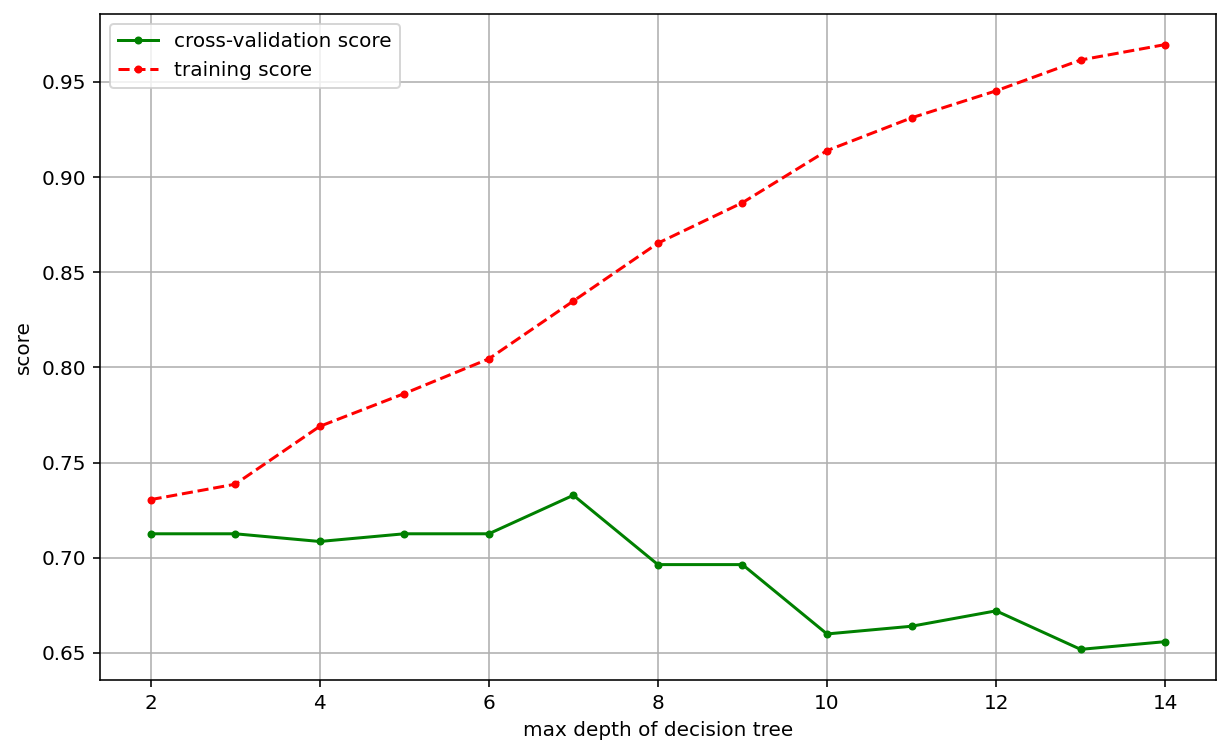

In [107]:
import numpy as np
# 参数选择 -max_depth
def cv_score(d):#该函数返回设置max_depth为某个值时得到的模型评估分数
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train, y_train)
    tr_score = clf.score(X_train, y_train)
    cv_score = clf.score(X_test, y_test)
    return (tr_score, cv_score)

depths = range(2, 15)
scores = [cv_score(d) for d in depths] #得到设置一系列max_depth值时，模型的评分
tr_scores = [s[0] for s in scores] #训练集得分
cv_scores = [s[1] for s in scores]#验证集得分

#得到最佳depth值
best_score_index = np.argmax(cv_scores) #选出评分最高的模型index
best_score = cv_scores[best_score_index]#根据这个index得到最高评分
best_param = depths[best_score_index]#根据这个index得到决策树最佳深度值
print('best param: {0}; best score: {1}'.format(best_param, best_score))

# 画出决策树最大深度与评分之间的关系
plt.figure(figsize=(10, 6), dpi=144)
plt.grid()
plt.xlabel('max depth of decision tree')
plt.ylabel('score')
plt.plot(depths, cv_scores, '.g-', label='cross-validation score')#测试集
plt.plot(depths, tr_scores, '.r--', label='training score')#训练集
plt.legend()

### (2)调整划分准则criterion
- 采用entropy（信息熵）或gini（基尼不纯度），设置他们的一系列阈值，选出最佳模型评分时的阈值
- 当低于该阈值时，不再生成新的枝叶

best param: 0.0018367346938775511; best score: 0.7368421052631579


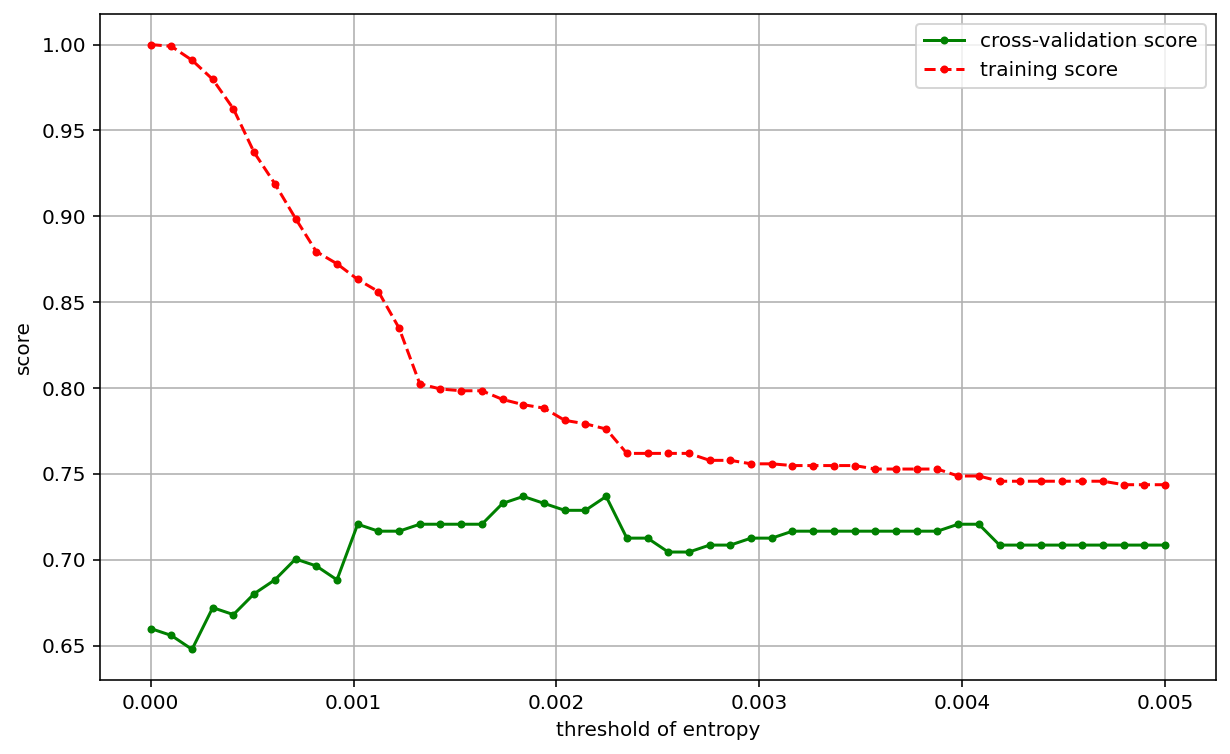

In [110]:
# 训练模型，并计算评分
def cv_score(val):#用基尼不纯度划分，设置基尼不纯度阈值
    clf = DecisionTreeClassifier(criterion='gini', min_impurity_decrease=val)
    clf.fit(X_train, y_train)
    tr_score = clf.score(X_train, y_train)
    cv_score = clf.score(X_test, y_test)
    return (tr_score, cv_score)

# 指定参数范围，分别训练模型，并计算评分
values = np.linspace(0, 0.005, 50)#将基尼不纯度指定为0到0.005之间均分的50个值
scores = [cv_score(v) for v in values]
tr_scores = [s[0] for s in scores]
cv_scores = [s[1] for s in scores]

# 找出评分最高的模型参数
best_score_index = np.argmax(cv_scores)
best_score = cv_scores[best_score_index]
best_param = values[best_score_index]
print('best param: {0}; best score: {1}'.format(best_param, best_score))

# 画出模型参数与模型评分的关系
plt.figure(figsize=(10, 6), dpi=144)
plt.grid()
plt.xlabel('threshold of entropy')
plt.ylabel('score')
plt.plot(values, cv_scores, '.g-', label='cross-validation score')
plt.plot(values, tr_scores, '.r--', label='training score')
plt.legend()

### (3)多参数联合考虑

- 使用 GridSearchCV（网格搜索）实现多参数（如同时考虑最大深度，基尼不纯度等参数）联合考虑
class sklearn.model_selection.GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, n_jobs=1, iid=True, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)
- 其关键参数是param_grid，这是一个字典，字典key值是待考查的参数名列表，通过枚举该列表所有值构建模型，多次计算训练模型，并得到模型评分
- 另一个关键字是cv，表示进行交叉验证的的规则，cv=5表示五折交叉验证
- 最终得到的最优参数和最高评分保存在clf.best_params和clf.best_score中
- clf.cv_results_保存了计算过程的中间结果，可以用于绘图看模型参数与模型评分的关系
- 我们先用min_impurity_decrease（节点划分最小不纯度,这个值限制了决策树的增长，如果某节点的不纯度小于这个阈值，则该节点不再生成子节点。）看看怎么使用

In [114]:
#画图代码，用于画出gridsearch方法中不同参数配置及评分
def plot_curve(train_sizes, cv_results, xlabel):
    train_scores_mean = cv_results['mean_train_score']#训练集评分均值
    train_scores_std = cv_results['std_train_score']# 训练集评分标准差
    test_scores_mean = cv_results['mean_test_score']#测试集评分均值
    test_scores_std = cv_results['std_test_score']# 测试集评分标准差
    plt.figure(figsize=(10, 6), dpi=144)
    plt.title('parameters turning')
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('score')
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1, color="r")
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, '.--', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, '.-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

best param: {'min_impurity_decrease': 0.004591836734693878}
best score: 0.6597511602646391


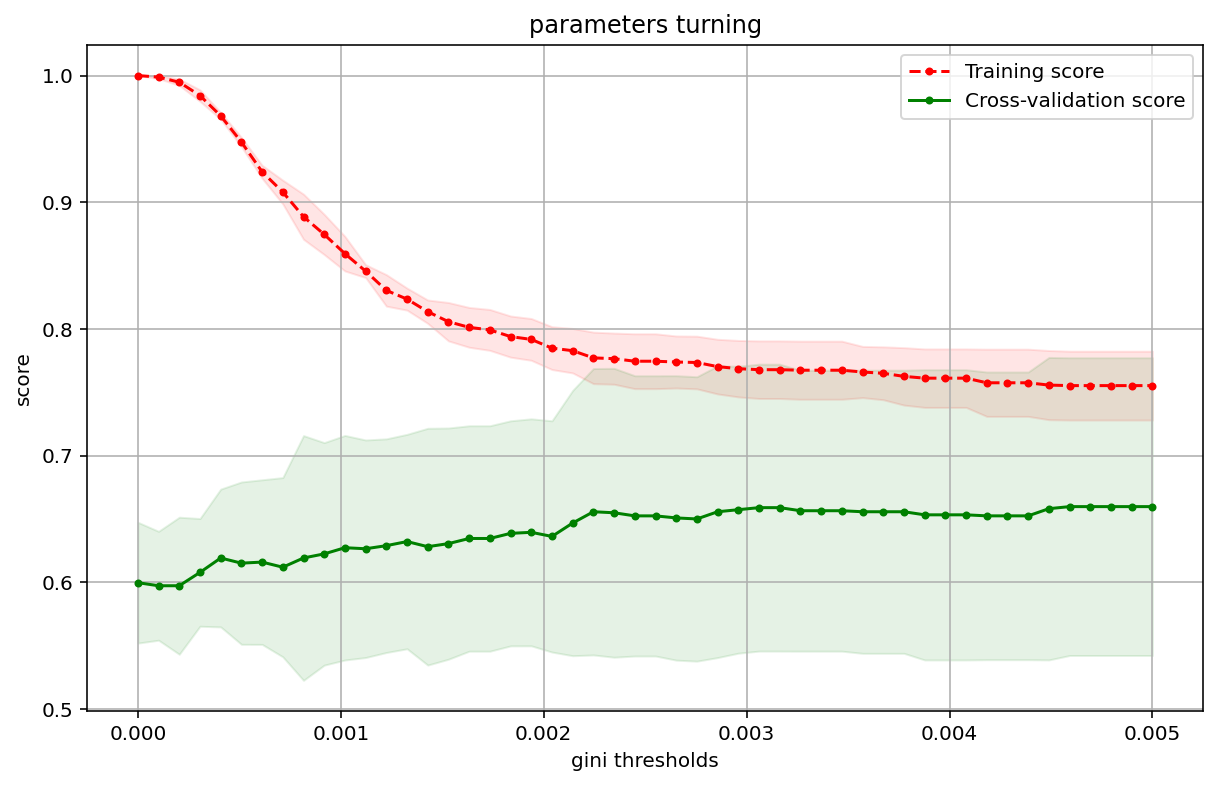

In [116]:
from sklearn.model_selection import GridSearchCV

thresholds = np.linspace(0, 0.005, 50) #gini阈值
# Set the parameters by cross-validation
param_grid = {'min_impurity_decrease': thresholds} #通过一个字典，定义要观察的参数和参数值，这里观察最小不纯度
#对设置参数后得到的模型进行五折交叉验证，返回训练集评分
clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, return_train_score=True)
clf.fit(X, y)
print("best param: {0}\nbest score: {1}".format(clf.best_params_, 
                                                clf.best_score_))

plot_curve(thresholds, clf.cv_results_, xlabel='gini thresholds')#画出gini不同阈值的评分结果

考虑多组变量（一个{}中包含一组变量的名字和取值）：
- 同时设置criterion（entropy，即划分准则）和min_impurity_decrease（最小信息增益不纯度）
- 同时设置criterion（entropy或gini，即划分准则）和min_impurity_decrease（最小基尼不纯度）
- 同时设置max_depth（最大深度）和min_samples_split（内部节点再划分所需最小样本数）

In [119]:
from sklearn.model_selection import GridSearchCV

entropy_thresholds = np.linspace(0, 0.01, 50)
gini_thresholds = np.linspace(0, 0.005, 50)

# Set the parameters by cross-validation
param_grid = [{'criterion': ['entropy'], 
               'min_impurity_decrease': entropy_thresholds},#同时设置criterion和min_impurity_decrease
              {'criterion': ['gini'], 
               'min_impurity_decrease': gini_thresholds},#同时设置criterion和min_impurity_decrease
              {'max_depth': range(2, 10)},
              {'min_samples_split': range(2, 30, 2)}]#同时设置criterion和min_impurity_decrease

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, return_train_score=True)#配置最佳参数，并且为每一对参数进行交叉验证
clf.fit(X, y)
print("best param: {0}\nbest score: {1}".format(clf.best_params_, 
                                                clf.best_score_))
cv_result = pd.DataFrame.from_dict(clf.cv_results_) #将结果写入csv文件
with open('cv_result.csv','w') as f:
 cv_result.to_csv(f)

best param: {'max_depth': 3}
best score: 0.6759454922484448


## 生成决策树图形
- 用上述选择出的模型参数进行训练，画出决策树

In [122]:
clf = DecisionTreeClassifier(criterion='entropy',min_impurity_decrease=0.0069387755102040816)
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print('train score: {0}; test score: {1}'.format(train_score, test_score))

# 导出 titanic.dot 文件
with open("students_dt_2.dot", 'w') as f:
    f = export_graphviz(clf, out_file=f)


import pydotplus  
#导出为pdf
dot_data = tree.export_graphviz(clf, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("students_dt_2.pdf")

train score: 0.75177304964539; test score: 0.7165991902834008


True

## 4.预测结果分析
- 通过决策树识别关键预测因子
由于决策树是按照最佳划分属性对数据集进行划分，所以越上层的划分属性越重要

In [125]:
labels = data.columns.tolist()
print(labels)

['UserClass', 'grade', 'gender', 'majorClass', 'totalLearningTime', 'TimeClassNumber', 'LocationClassNumber', 'isPassExam']


## 5.案例练习
使用预处理好的数据集student_data_DT2.csv，搭建决策树模型，选择若干个输入变量（2个或2个以上，可以全选）预测学生学习成绩(1-不通过考试，0-通过考试)；
- 正确搭建模型；
- 尝试设置不同的参数，运行模型，观察评分变化，观察决策树可视化的变化
- 使用网格搜索找出可能的最佳参数
- 分析预测成绩的关键预测因子